# Задание 1

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Есть интересное обсуждение насчет использования начальной нормализации, но я сделаю как в семинаре [ссылка на обсуждение](https://discuss.pytorch.org/t/discussion-why-normalise-according-to-imagenet-mean-and-std-dev-for-transfer-learning/115670)

Загружаем датасет

In [ ]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import v2
from torch.utils.data import DataLoader

fashion_transform = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.5], [0.25])
])

train_dataset = FashionMNIST(root="/content", download=True, train=True, transform=fashion_transform)
test_dataset = FashionMNIST(root="/content", download=True, train=False, transform=fashion_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.97MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 61.5MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.0MB/s]


In [ ]:
print(f"Размерность картинок: {train_dataset[0][0].shape}")

Размерность картинок: torch.Size([1, 28, 28])


Выведем примеры объектов в датасете

In [ ]:
cloth_names = train_dataset.classes

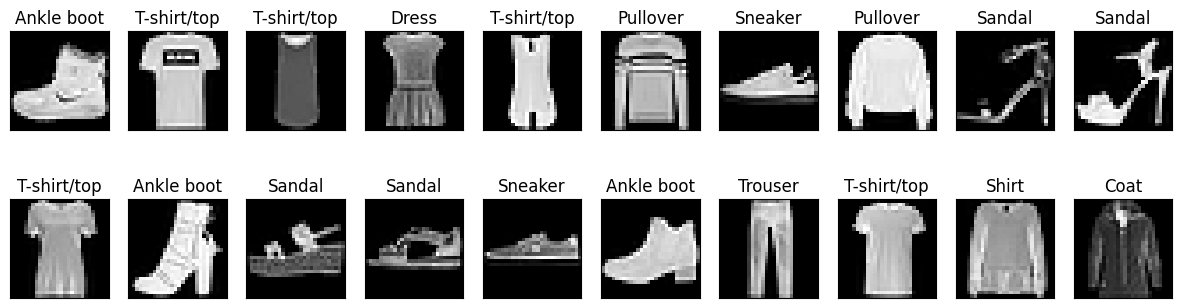

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))

for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(train_dataset[i][0].permute(1, 2, 0), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(cloth_names[train_dataset[i][1]])

plt.show()

Разделим датасет на трейновую и валидационную часть

In [ ]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(train_dataset, (0.85, 0.15))

val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

Объявим полносвязную нейронную сеть с регуляризацией

In [ ]:
from torch import nn
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.flt = nn.Flatten(start_dim=-3)

        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)
        self.do = nn.Dropout(0.3)

    def forward(self, x):
        x = self.flt(x)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.do(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.do(x)

        x = self.fc3(x)

        return x

model = Net().to(device)

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
       BatchNorm1d-3                  [-1, 256]             512
              ReLU-4                  [-1, 256]               0
           Dropout-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
       BatchNorm1d-7                  [-1, 128]             256
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 235,914
Trainable params: 235,914
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.90
Estimated T

Буду использовать кросс- энтропию и оптимизатор Адам

In [ ]:
critertion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
!pip3 install pytorch-ignite

Создам trainer и evaluator, задам метрики

In [ ]:
from ignite.engine import create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Accuracy, Loss

trainer = create_supervised_trainer(model, optimizer, critertion, device)

metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(critertion)
}

val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

Напишем несколько хэндлеров для логирования и построения графиков обучения

In [ ]:
from ignite.engine import Events

@trainer.on(Events.ITERATION_COMPLETED(every=1000))
def log_iter_loss(engine):
    print(f"Epoch[{engine.state.epoch}] - Iter[{engine.state.iteration}]: loss = {engine.state.output:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def compute_epoch_results(engine):
    train_evaluator.run(train_dataloader)
    val_evaluator.run(val_dataloader)

def log_epoch_loss(engine, label=""):
    result = ", ".join([f"{m} = {v}" for m, v in engine.state.metrics.items()])
    print(f"{label}, Res: {result}")

@trainer.on(Events.STARTED)
def metrics_history_init(engine):
    engine.state.epoch_history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
    }

@val_evaluator.on(Events.EPOCH_COMPLETED)
def append_metrics(engine):
    trainer.state.epoch_history['val_loss'].append(engine.state.metrics['loss'])
    trainer.state.epoch_history['val_acc'].append(engine.state.metrics['accuracy'])

@train_evaluator.on(Events.EPOCH_COMPLETED)
def append_metrics(engine):
    trainer.state.epoch_history['train_loss'].append(engine.state.metrics['loss'])
    trainer.state.epoch_history['train_acc'].append(engine.state.metrics['accuracy'])

@trainer.on(Events.COMPLETED)
def plot_metrics(engine):
    history = engine.state.epoch_history

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    ax1.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax1.plot(history['val_acc'], label='Valid Accuracy', color='orange')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_loss'], label='Train Loss', color='blue')
    ax2.plot(history['val_loss'], label='Valid Loss', color='orange')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_loss, label="Train")
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_loss, label="Valid")

Добавим scheduler для лучшей сходимости в минимум

In [ ]:
from ignite.handlers.param_scheduler import ReduceLROnPlateauScheduler

scheduler = ReduceLROnPlateauScheduler(
    optimizer,
    metric_name="loss",
    factor=0.5,
    patience=1,
    threshold=0.05
)

def print_lr():
    for param_group in optimizer.param_groups:
        print(f"Optimizer learning rate = {param_group['lr']}")

val_evaluator.add_event_handler(Events.COMPLETED, scheduler)
val_evaluator.add_event_handler(Events.COMPLETED, print_lr)

Добавлю чекпоинты, чтобы сохранять лучшие 3 модели

In [ ]:
from ignite.handlers import ModelCheckpoint

checkpoint_handler = ModelCheckpoint(
    dirname="/content/checkpoints",
    filename_prefix="best",
    score_name="val_accuracy",
    score_function=lambda engine: engine.state.metrics["accuracy"],
    n_saved=3,
    require_empty=False
)

val_evaluator.add_event_handler(
    Events.EPOCH_COMPLETED,
    checkpoint_handler,
    {"model": model}
)

Обучаем модель и строим график

Epoch[1] - Iter[1000]: loss = 0.23
Train, Res: accuracy = 0.8648666666666667, loss = 0.36638408203125
Valid, Res: accuracy = 0.8633333333333333, loss = 0.3661419270833333
Optimizer learning rate = 0.001
Epoch[2] - Iter[2000]: loss = 0.33
Epoch[2] - Iter[3000]: loss = 0.55
Train, Res: accuracy = 0.8817, loss = 0.3196365234375
Valid, Res: accuracy = 0.8815555555555555, loss = 0.31945364040798613
Optimizer learning rate = 0.001
Epoch[3] - Iter[4000]: loss = 0.23
Epoch[3] - Iter[5000]: loss = 0.38
Train, Res: accuracy = 0.8873, loss = 0.29962610677083334
Valid, Res: accuracy = 0.8877777777777778, loss = 0.2966928982204861
Optimizer learning rate = 0.001
Epoch[4] - Iter[6000]: loss = 0.40
Epoch[4] - Iter[7000]: loss = 0.29
Train, Res: accuracy = 0.8955166666666666, loss = 0.2798541341145833
Valid, Res: accuracy = 0.8973333333333333, loss = 0.27761387803819443
Optimizer learning rate = 0.001
Epoch[5] - Iter[8000]: loss = 0.43
Epoch[5] - Iter[9000]: loss = 0.28
Train, Res: accuracy = 0.901683

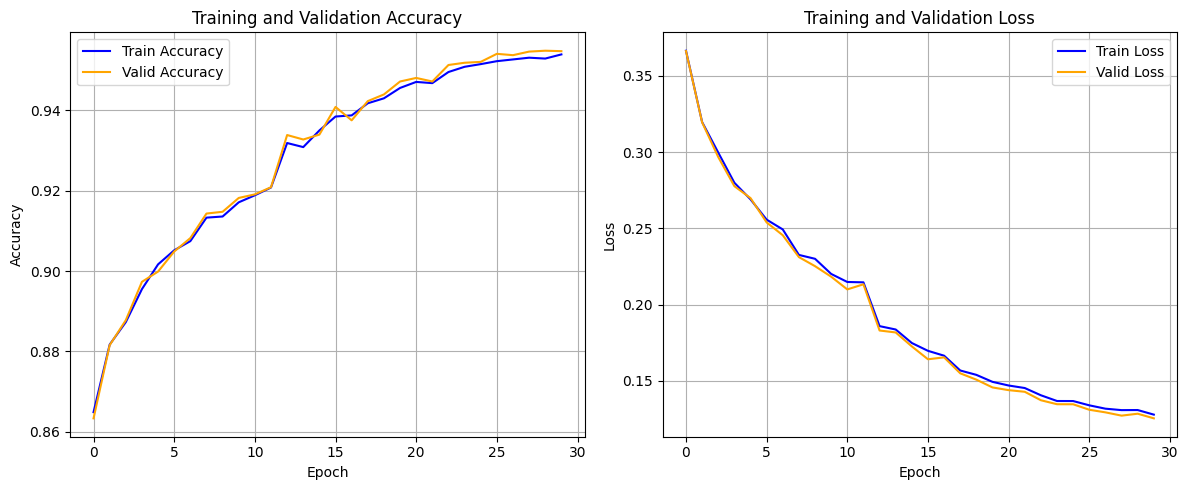

State:
	iteration: 56250
	epoch: 30
	epoch_length: 1875
	max_epochs: 30
	output: 0.23581038415431976
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>
	epoch_history: <class 'dict'>

In [ ]:
trainer.run(train_dataloader, 30)

По логу и графикам видно, что все хорошо: лосс падает, accuracy растет, переобучения не наблюдается <p>

Также по логу можно видеть, как уменьшается learning rate из-за добавленного шедулера, и на графиках видны бугорки - они показывают, где было уменьшение lr <p>

Возможно модель бы обучилась еще лучше, дал бы я ей больше эпох, но ресурсов у меня немного (она обучалась полчаса)

In [ ]:
print(f"Лучший accuracy за время обучения: {max(trainer.state.epoch_history['val_acc']):.4f}")
print(f"Наименьший лосс за время обучения: {max(trainer.state.epoch_history['val_loss']):.4f}")

Лучший accuracy за время обучения: 0.9549
Наименьший лосс за время обучения: 0.3661


Сохраним модель, чтобы не обучать заново, когда покинем сессию и вернемся

In [ ]:
checkpoint = {
    "epoch": trainer.state.epoch_length,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": scheduler.state_dict(),
    "epoch_history": trainer.state.epoch_history
}
torch.save(checkpoint, "/content/full_mlp_checkpoint.pth")

Код для загрузки модели

In [ ]:
checkpoint_mlp = torch.load("/content/full_mlp_checkpoint.pth", map_location='cpu', weights_only=False)

# Задача 2

Объявим сверточную нейронную сеть

In [ ]:
from torch import nn
from torchsummary import summary

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1),   #(32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),    #(64, 28, 28)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   #(64, 14, 14)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),    #(128, 14, 14)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   #(128, 7, 7)
        )


        self.flt = nn.Flatten(start_dim=-3)

        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)
        self.do = nn.Dropout(0.3)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.flt(x)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.do(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.do(x)

        x = self.fc3(x)

        return x

model = ConvNet().to(device)

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          18,496
       BatchNorm2d-5           [-1, 64, 28, 28]             128
              ReLU-6           [-1, 64, 28, 28]               0
         MaxPool2d-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]          73,856
       BatchNorm2d-9          [-1, 128, 14, 14]             256
             ReLU-10          [-1, 128, 14, 14]               0
        MaxPool2d-11            [-1, 128, 7, 7]               0
          Flatten-12                 [-1, 6272]               0
           Linear-13                  [-1, 256]       1,605,888
      BatchNorm1d-14                  [

In [ ]:
critertion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Так же как и в прошлом задании пользуемся ignite
(я пользовался декораторами, поэтому просто скопирую код)

In [ ]:
from ignite.engine import create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Accuracy, Loss

trainer = create_supervised_trainer(model, optimizer, critertion, device)

metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(critertion)
}

val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

In [ ]:
from ignite.engine import Events

@trainer.on(Events.ITERATION_COMPLETED(every=1000))
def log_iter_loss(engine):
    print(f"Epoch[{engine.state.epoch}] - Iter[{engine.state.iteration}]: loss = {engine.state.output:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def compute_epoch_results(engine):
    train_evaluator.run(train_dataloader)
    val_evaluator.run(val_dataloader)

def log_epoch_loss(engine, label=""):
    result = ", ".join([f"{m} = {v}" for m, v in engine.state.metrics.items()])
    print(f"{label}, Res: {result}")

@trainer.on(Events.STARTED)
def metrics_history_init(engine):
    engine.state.epoch_history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
    }

@val_evaluator.on(Events.EPOCH_COMPLETED)
def append_metrics(engine):
    trainer.state.epoch_history['val_loss'].append(engine.state.metrics['loss'])
    trainer.state.epoch_history['val_acc'].append(engine.state.metrics['accuracy'])

@train_evaluator.on(Events.EPOCH_COMPLETED)
def append_metrics(engine):
    trainer.state.epoch_history['train_loss'].append(engine.state.metrics['loss'])
    trainer.state.epoch_history['train_acc'].append(engine.state.metrics['accuracy'])

@trainer.on(Events.COMPLETED)
def plot_metrics(engine):
    history = engine.state.epoch_history

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    ax1.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax1.plot(history['val_acc'], label='Valid Accuracy', color='orange')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_loss'], label='Train Loss', color='blue')
    ax2.plot(history['val_loss'], label='Valid Loss', color='orange')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_loss, label="Train")
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_loss, label="Valid")

In [ ]:
from ignite.handlers.param_scheduler import ReduceLROnPlateauScheduler

scheduler = ReduceLROnPlateauScheduler(
    optimizer,
    metric_name="loss",
    factor=0.5,
    patience=1,
    threshold=0.05
)

def print_lr():
    for param_group in optimizer.param_groups:
        print(f"Optimizer learning rate = {param_group['lr']}")

val_evaluator.add_event_handler(Events.COMPLETED, scheduler)
val_evaluator.add_event_handler(Events.COMPLETED, print_lr)

In [ ]:
from ignite.handlers import ModelCheckpoint

checkpoint_handler = ModelCheckpoint(
    dirname="/content/checkpoints",
    filename_prefix="best",
    score_name="val_accuracy",
    score_function=lambda engine: engine.state.metrics["accuracy"],
    n_saved=3,
    require_empty=False
)

val_evaluator.add_event_handler(
    Events.EPOCH_COMPLETED,
    checkpoint_handler,
    {"model": model}
)

Обучаем CNN

Epoch[1] - Iter[1000]: loss = 0.25
Train, Res: accuracy = 0.92225, loss = 0.21151263020833333
Valid, Res: accuracy = 0.922, loss = 0.2112589382595486
Optimizer learning rate = 0.001
Epoch[2] - Iter[2000]: loss = 0.37
Epoch[2] - Iter[3000]: loss = 0.08
Train, Res: accuracy = 0.9412333333333334, loss = 0.16029775390625
Valid, Res: accuracy = 0.939, loss = 0.16040037706163193
Optimizer learning rate = 0.001
Epoch[3] - Iter[4000]: loss = 0.19
Epoch[3] - Iter[5000]: loss = 0.22
Train, Res: accuracy = 0.9527166666666667, loss = 0.131351220703125
Valid, Res: accuracy = 0.9487777777777778, loss = 0.13215010579427083
Optimizer learning rate = 0.001
Epoch[4] - Iter[6000]: loss = 0.11
Epoch[4] - Iter[7000]: loss = 0.33
Train, Res: accuracy = 0.9644166666666667, loss = 0.10235082194010417
Valid, Res: accuracy = 0.9621111111111111, loss = 0.1050744900173611
Optimizer learning rate = 0.001
Epoch[5] - Iter[8000]: loss = 0.14
Epoch[5] - Iter[9000]: loss = 0.08
Train, Res: accuracy = 0.9726, loss = 0.0

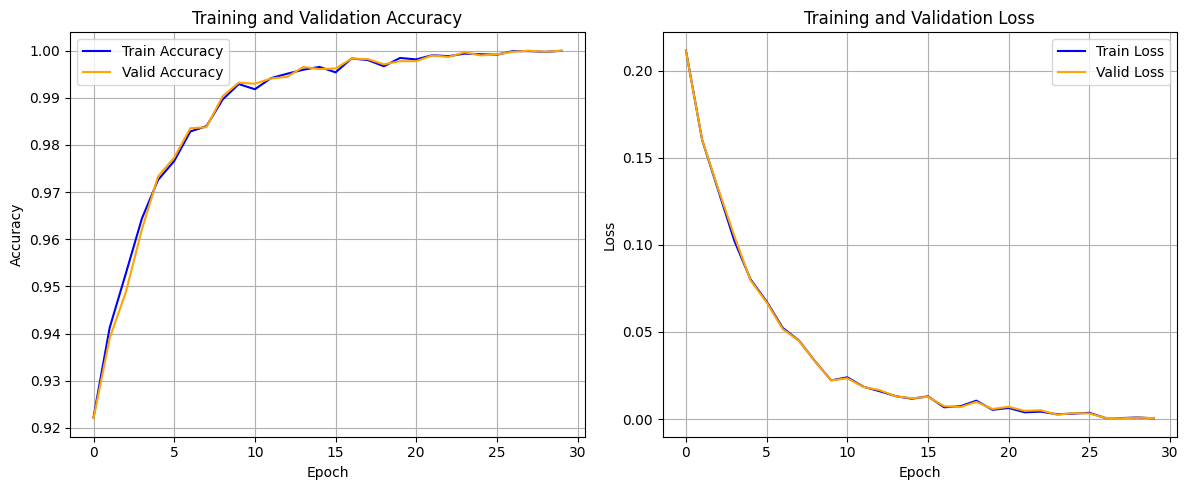

State:
	iteration: 56250
	epoch: 30
	epoch_length: 1875
	max_epochs: 30
	output: 0.006179303862154484
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>
	epoch_history: <class 'dict'>

In [ ]:
trainer.run(train_dataloader, 30)

In [ ]:
print(f"Лучший accuracy за время обучения: {max(trainer.state.epoch_history['val_acc']):.4f}")

Лучший accuracy за время обучения: 1.0000


По логу и графикам видно, что все хорошо: лосс падает, accuracy растет, переобучения не наблюдается <p>
по метрикам и графику видно, что с большим перевесом выигрывает сверточная нейронная сеть, accuracy достиг 0.99 еще на первых эпохах, learning rate почти не изменился с начала обучения, а значит что лосс все время падал. <p>

Сохраняем модель

In [ ]:
checkpoint = {
    "epoch": trainer.state.epoch_length,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": scheduler.state_dict(),
    "epoch_history": trainer.state.epoch_history
}
torch.save(checkpoint, "/content/full_conv_checkpoint.pth")

Загрузим модель

In [ ]:
checkpoint_test = torch.load("/content/full_conv_checkpoint.pth", map_location='cpu', weights_only=False)

Сравним графики для полносвязной и сверточной нейросетей

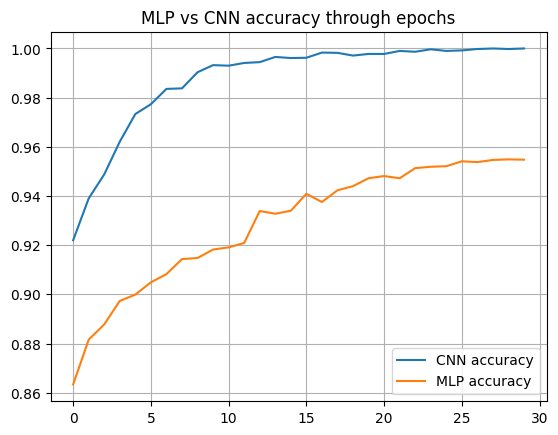

In [ ]:
plt.figure()

plt.plot(checkpoint_test['epoch_history']['val_acc'], label='CNN accuracy')
plt.plot(checkpoint_mlp['epoch_history']['val_acc'], label='MLP accuracy')

plt.title("MLP vs CNN accuracy through epochs")
plt.legend()
plt.grid()

plt.show()

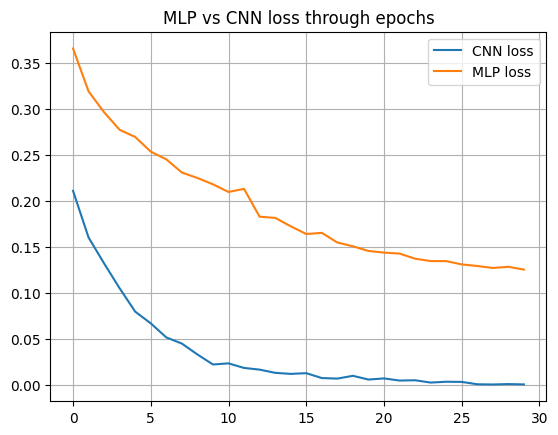

In [ ]:
plt.figure()

plt.plot(checkpoint_test['epoch_history']['val_loss'], label='CNN loss')
plt.plot(checkpoint_mlp['epoch_history']['val_loss'], label='MLP loss')

plt.title("MLP vs CNN loss through epochs")
plt.legend()
plt.grid()

plt.show()

Наглядно видно как CNN выигрывает

# Задача 3

In [ ]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import v2
from torch.utils.data import DataLoader

fashion_transform = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.5], [0.25])
])

train_transforms = v2.Compose([
    v2.RandomAffine(
        degrees=50,
        translate=(0.1, 0.2),
        scale=(0.8, 1.2),
        shear=30
        ),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.5], [0.25])
])

train_dataset = FashionMNIST(root="/content", download=True, train=True, transform=train_transforms)
test_dataset = FashionMNIST(root="/content", download=True, train=False, transform=fashion_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 278kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.04MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.2MB/s]


In [ ]:
cloth_names = train_dataset.classes

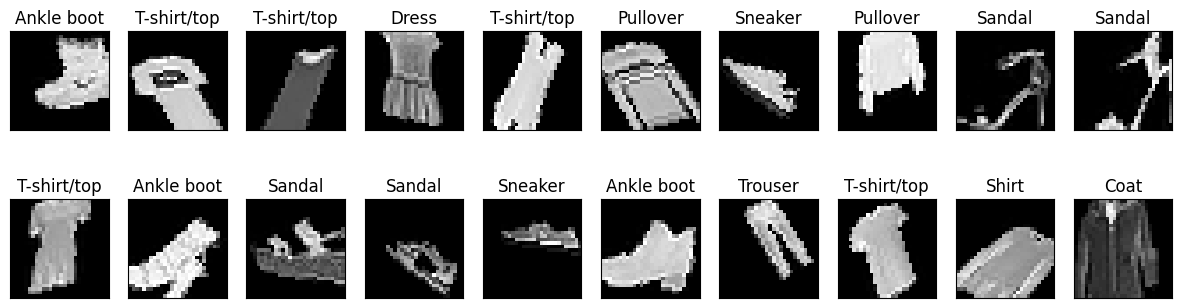

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))

for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(train_dataset[i][0].permute(1, 2, 0), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(cloth_names[train_dataset[i][1]])

plt.show()

In [ ]:
from torch import nn
from torchsummary import summary

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1),   #(32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),    #(64, 28, 28)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   #(64, 14, 14)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),    #(128, 14, 14)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   #(128, 7, 7)
        )


        self.flt = nn.Flatten(start_dim=-3)

        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)
        self.do = nn.Dropout(0.3)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.flt(x)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.do(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.do(x)

        x = self.fc3(x)

        return x

model = ConvNet().to(device)

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          18,496
       BatchNorm2d-5           [-1, 64, 28, 28]             128
              ReLU-6           [-1, 64, 28, 28]               0
         MaxPool2d-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]          73,856
       BatchNorm2d-9          [-1, 128, 14, 14]             256
             ReLU-10          [-1, 128, 14, 14]               0
        MaxPool2d-11            [-1, 128, 7, 7]               0
          Flatten-12                 [-1, 6272]               0
           Linear-13                  [-1, 256]       1,605,888
      BatchNorm1d-14                  [

In [ ]:
critertion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
!pip3 install pytorch-ignite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 845.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
from ignite.engine import create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Accuracy, Loss

trainer = create_supervised_trainer(model, optimizer, critertion, device)

metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(critertion)
}

val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

In [ ]:
from ignite.engine import Events

@trainer.on(Events.ITERATION_COMPLETED(every=1000))
def log_iter_loss(engine):
    print(f"Epoch[{engine.state.epoch}] - Iter[{engine.state.iteration}]: loss = {engine.state.output:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def compute_epoch_results(engine):
    train_evaluator.run(train_dataloader)
    val_evaluator.run(val_dataloader)

def log_epoch_loss(engine, label=""):
    result = ", ".join([f"{m} = {v}" for m, v in engine.state.metrics.items()])
    print(f"{label}, Res: {result}")

@trainer.on(Events.STARTED)
def metrics_history_init(engine):
    engine.state.epoch_history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
    }

@val_evaluator.on(Events.EPOCH_COMPLETED)
def append_metrics(engine):
    trainer.state.epoch_history['val_loss'].append(engine.state.metrics['loss'])
    trainer.state.epoch_history['val_acc'].append(engine.state.metrics['accuracy'])

@train_evaluator.on(Events.EPOCH_COMPLETED)
def append_metrics(engine):
    trainer.state.epoch_history['train_loss'].append(engine.state.metrics['loss'])
    trainer.state.epoch_history['train_acc'].append(engine.state.metrics['accuracy'])

@trainer.on(Events.COMPLETED)
def plot_metrics(engine):
    history = engine.state.epoch_history

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    ax1.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax1.plot(history['val_acc'], label='Valid Accuracy', color='orange')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_loss'], label='Train Loss', color='blue')
    ax2.plot(history['val_loss'], label='Valid Loss', color='orange')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_loss, label="Train")
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_loss, label="Valid")

In [ ]:
from ignite.handlers.param_scheduler import ReduceLROnPlateauScheduler

scheduler = ReduceLROnPlateauScheduler(
    optimizer,
    metric_name="loss",
    factor=0.5,
    patience=1,
    threshold=0.05
)

def print_lr():
    for param_group in optimizer.param_groups:
        print(f"Optimizer learning rate = {param_group['lr']}")

val_evaluator.add_event_handler(Events.COMPLETED, scheduler)
val_evaluator.add_event_handler(Events.COMPLETED, print_lr)

In [ ]:
from ignite.handlers import ModelCheckpoint

checkpoint_handler = ModelCheckpoint(
    dirname="/content/checkpoints",
    filename_prefix="best",
    score_name="val_accuracy",
    score_function=lambda engine: engine.state.metrics["accuracy"],
    n_saved=3,
    require_empty=False
)

val_evaluator.add_event_handler(
    Events.EPOCH_COMPLETED,
    checkpoint_handler,
    {"model": model}
)

In [ ]:
trainer.run(train_dataloader, 30)

Epoch[1] - Iter[1000]: loss = 1.01


ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: name 'val_dataloader' is not defined


Train, Res: accuracy = 0.7379, loss = 0.6898767578125


NameError: name 'val_dataloader' is not defined